In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import time

import numpy as np

import torch
import torch.nn.functional as F

import cv2

import matplotlib
import matplotlib.pyplot as plt

from viz_svls import LS, SVLS
from datasets import get_datasets_brats

In [2]:
ls = LS(4, 0.1).cuda()
svls = SVLS(4, 1.0).cuda()

In [3]:
DATA_PATH = '/home/s2018013343/project/exp4_dl/SVLS/MICCAI_BraTS_2019_Data_Training/HGG_LGG'

train_dataset, val_dataset = get_datasets_brats(data_root=DATA_PATH)

选取样本

In [154]:
sample_idx = 80

item = train_dataset[sample_idx]
label = item['label'].cuda()
image = item['image'].float().cuda()

label_oh = torch.permute(F.one_hot(label), (0, 4, 1, 2, 3))
label_ls = ls(label)
label_svls = svls(label)

label_oh_ = label_oh.cpu().numpy()
label_ls_ = label_ls.cpu().numpy()
label_svls_ = label_svls.cpu().numpy()

print(label_oh_.shape)
print(label_ls_.shape)
print(label_svls_.shape)

(1, 4, 128, 192, 192)
(1, 4, 128, 192, 192)
(1, 4, 128, 192, 192)


可视化样本

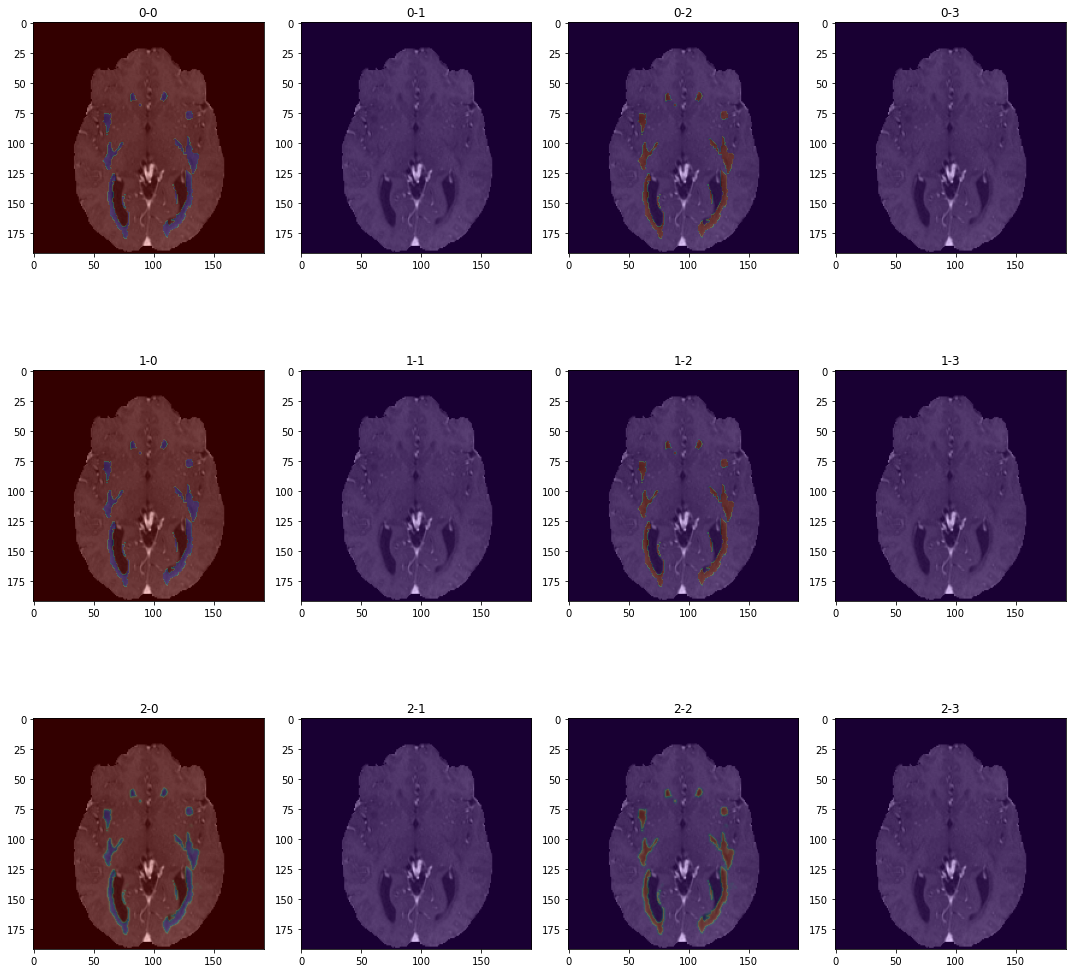

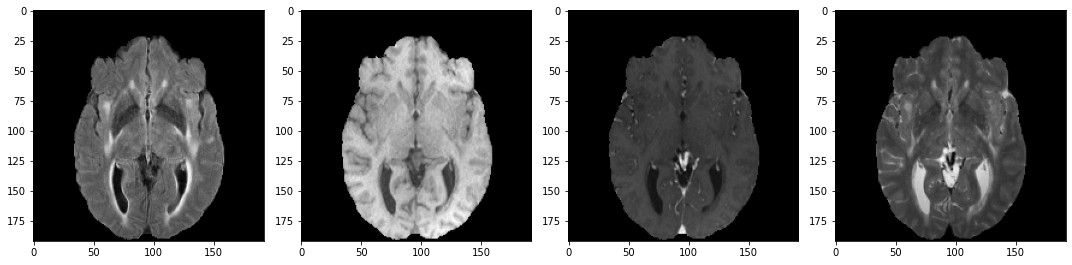

In [155]:
depth = 60

label_slice_oh = label_oh[0, :, depth, ...].cpu().numpy()
label_slice_ls = label_ls[0, :, depth, ...].cpu().numpy()
label_slice_svls = label_svls[0, :, depth, ...].cpu().numpy()


image_slice = image[:, depth, ...].cpu().numpy()


figure, axs = plt.subplots(3, 4, figsize=(15, 15))

_slices = [label_slice_oh, label_slice_ls, label_slice_svls]

for _type in range(3):
    _slice = _slices[_type]
    for _class in range(4):
        # print(f'{_type}-{_class}')
        # print(np.unique(_slice[_class+1]))
        axs[_type, _class].imshow(_slice[_class], cmap='rainbow')
        axs[_type, _class].imshow(image_slice[2], alpha=0.8, cmap='gray')
        axs[_type, _class].set_title(f'{_type}-{_class}')
plt.tight_layout()
plt.show()

figure, axs = plt.subplots(1, 4, figsize=(15, 15))
for seq in range(4):
    axs[seq].imshow(image_slice[seq], cmap='gray')
plt.tight_layout()
plt.show()

### svls(scale-factor=1)

In [156]:
pass

### svls(scale-factor=2)

In [157]:
def scale_svls(label, operator=None, scale_factor=2.0):
    n, z, x, y = label.shape
    
    if operator is None:
        svls = SVLS(classes=4).cuda()
    else:
        svls = operator

    aff = torch.FloatTensor([[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]]])
    aff.expand(n, 3, 4)
    grid_up = torch.nn.functional.affine_grid(aff, size=(n, 1, int(scale_factor * z), int(scale_factor * x), int(scale_factor * y))).cuda()
    grid_down = torch.nn.functional.affine_grid(aff, size=(n, 1, z, x, y)).cuda()

    # up sample
    label_resample = F.grid_sample(label[:, None, ...].float(), grid_up, mode='nearest')

    # svls
    label_resample_svls = svls(label_resample[:, 0, ...])

    # down sample
    label_resample_svls_resample = F.grid_sample(label_resample_svls.float(), grid_down, mode='bilinear')

    return label_resample_svls_resample

In [158]:
label_svls_scale_2 = scale_svls(label, operator=svls)
label_svls_scale_2_ = label_svls_scale_2.cpu().numpy()

label_svls_scale_2_.shape

(1, 4, 128, 192, 192)

### svls(sv-mix-scale)


前景，腐蚀，连通域，扩展

In [159]:
from skimage import morphology, measure, segmentation

# get non-background voxel
label_foreground_ = (label_oh_[:, :1] == 0).astype(int)

# erosion
label_foreground_erosion_ = morphology.erosion(label_foreground_[0, 0], morphology.octahedron(3))[None, None, ...]

# get domains
label_foreground_erosion_domain_, num = \
    measure.label(label_foreground_erosion_[0, 0], return_num=True, connectivity=1)
label_foreground_erosion_domain_ = label_foreground_erosion_domain_[None, None, ...]

# expand the domains
label_foreground_erosion_domain_expand_ = segmentation.expand_labels(label_foreground_erosion_domain_, 3)

print(label_foreground_erosion_domain_expand_.shape)

(1, 1, 128, 192, 192)


可视化结果

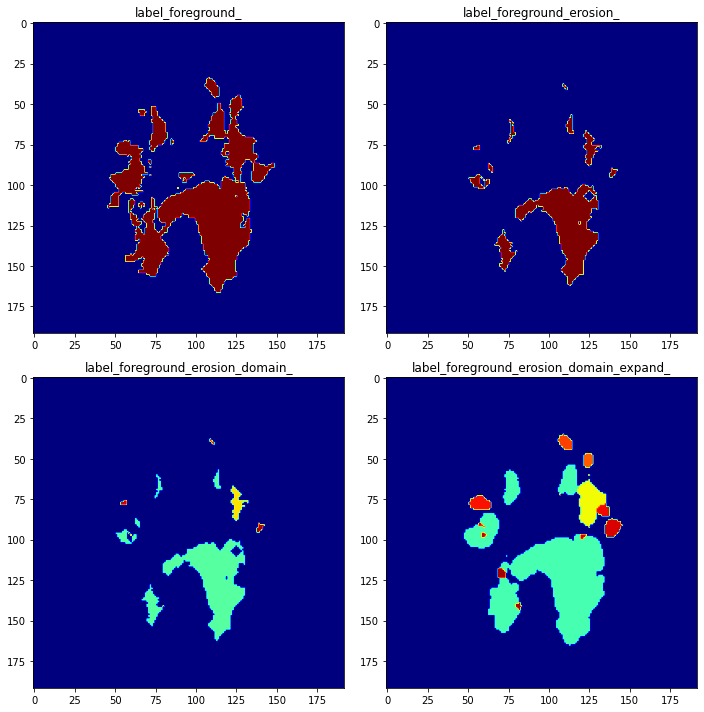

In [160]:
depth = 80

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axs.ravel()
ax1.imshow(label_foreground_[0, 0, depth], cmap='jet')
ax1.set_title('label_foreground_')
ax2.imshow(label_foreground_erosion_[0, 0, depth], cmap='jet')
ax2.set_title('label_foreground_erosion_')
ax3.imshow(label_foreground_erosion_domain_[0, 0, depth], cmap='jet')
ax3.set_title('label_foreground_erosion_domain_')
ax4.imshow(label_foreground_erosion_domain_expand_[0, 0, depth], cmap='jet')
ax4.set_title('label_foreground_erosion_domain_expand_')
plt.tight_layout()
plt.show()

获取前景的dtm

In [161]:
from scipy.ndimage import distance_transform_edt as distance


label_foreground_dtm_ = distance(label_foreground_)

label_foreground_dtm01_ = label_foreground_dtm_ / np.max(label_foreground_dtm_)

print(label_foreground_dtm_.shape)
print(np.unique(label_foreground_dtm_))
print(label_foreground_dtm01_.shape)
print(np.unique(label_foreground_dtm01_))

(1, 1, 128, 192, 192)
[ 0.          1.          1.41421356  1.73205081  2.          2.23606798
  2.44948974  2.82842712  3.          3.16227766  3.31662479  3.46410162
  3.60555128  3.74165739  4.          4.12310563  4.24264069  4.35889894
  4.47213595  4.58257569  4.69041576  4.89897949  5.          5.09901951
  5.19615242  5.38516481  5.47722558  5.65685425  5.74456265  5.83095189
  5.91607978  6.          6.08276253  6.164414    6.32455532  6.40312424
  6.4807407   6.55743852  6.63324958  6.70820393  6.78232998  6.92820323
  7.          7.07106781  7.14142843  7.21110255  7.28010989  7.34846923
  7.48331477  7.54983444  7.61577311  7.68114575  7.81024968  7.87400787
  8.          8.06225775  8.1240384   8.18535277  8.24621125  8.30662386
  8.36660027  8.48528137  8.54400375  8.60232527  8.66025404  8.71779789
  8.77496439  8.83176087  8.94427191  9.          9.05538514  9.11043358
  9.16515139  9.21954446  9.2736185   9.38083152  9.43398113  9.48683298
  9.53939201  9.64365076  9.6

计算处理后连通域的sv

In [162]:
label_domain_sv = np.ones_like(label_foreground_erosion_domain_expand_, dtype=float)

for i in range(1, num+1):  # exclude background
    surface_area = np.sum(label_foreground_dtm_[label_foreground_erosion_domain_expand_==i]==1)
    volume = np.sum(label_foreground_erosion_domain_expand_==i)
    # print(surface_area)
    # print(volume)
    # print(surface_area / volume)
    label_domain_sv[label_foreground_erosion_domain_expand_==i] = surface_area / volume
    # print(np.unique(label_domain_sv))

print(len(np.unique(label_domain_sv)))
print(np.unique(label_domain_sv))
print(label_domain_sv.shape)

107
[0.125      0.15625    0.1635975  0.17647059 0.19642857 0.2
 0.20454545 0.21276596 0.21428571 0.21590909 0.21666667 0.2173913
 0.22222222 0.22413793 0.2244898  0.22641509 0.22727273 0.22764228
 0.23       0.23033708 0.23076923 0.23809524 0.23846154 0.23913043
 0.24137931 0.24285714 0.24705882 0.25       0.25092707 0.25203252
 0.25510204 0.25531915 0.25555556 0.26027397 0.26086957 0.26666667
 0.26684636 0.26923077 0.27027027 0.27131783 0.27222222 0.27272727
 0.2739726  0.27419355 0.275      0.27777778 0.27906977 0.27974277
 0.28199052 0.28205128 0.28235294 0.28301887 0.28490566 0.28571429
 0.28729282 0.28767123 0.28804095 0.2892562  0.29032258 0.29213483
 0.29219601 0.29411765 0.29425837 0.29508197 0.29565217 0.2962963
 0.29824561 0.2987013  0.29885057 0.29896907 0.3        0.30107527
 0.30136986 0.30344828 0.30769231 0.30952381 0.3100304  0.31130435
 0.31300161 0.31428571 0.31707317 0.31730769 0.31914894 0.3202847
 0.32178218 0.32352941 0.32512315 0.33015873 0.33333333 0.34
 0.3431

获取multi-scale的svls标签

In [163]:
scales = [1.0, 1.3, 1.6, 2.0]

label_multi_scale_svls = list()

for scale in scales:
    label_scale_svls = scale_svls(label, operator=svls, scale_factor=scale)
    label_scale_svls_ = label_scale_svls.cpu().numpy()
    label_multi_scale_svls.append(label_scale_svls_)

label_multi_scale_svls = np.stack(label_multi_scale_svls, axis=-1)

label_multi_scale_svls.shape

(1, 4, 128, 192, 192, 4)

根据sv分配合适的scale

In [164]:
label_domain_sv_scale = np.round(label_domain_sv * 3).astype(int)

print(np.max(label_domain_sv_scale))
print(np.min(label_domain_sv_scale))
print(label_domain_sv_scale.shape)

3
0
(1, 1, 128, 192, 192)


得到混合尺度标签

In [165]:
label_svls_sv_mix_ = np.zeros_like(label_svls_)

label_svls_sv_mix_.shape

label_svls_sv_mix_ = \
    np.where(label_domain_sv_scale==0, label_multi_scale_svls[..., 0], label_svls_sv_mix_)
label_svls_sv_mix_ = \
    np.where(label_domain_sv_scale==1, label_multi_scale_svls[..., 1], label_svls_sv_mix_)
label_svls_sv_mix_ = \
    np.where(label_domain_sv_scale==2, label_multi_scale_svls[..., 2], label_svls_sv_mix_)
label_svls_sv_mix_ = \
    np.where(label_domain_sv_scale==3, label_multi_scale_svls[..., 3], label_svls_sv_mix_)

label_svls_sv_mix_.shape

(1, 4, 128, 192, 192)

### svls(dtm-mix-scale)

根据dtm01分配合适的scale

In [166]:
scales = 3

label_dtm01_scale = np.round(label_foreground_dtm01_ * scales)
label_dtm01_scale = (label_dtm01_scale - 3) * -1
label_dtm01_scale = label_dtm01_scale.astype(int)

print(label_dtm01_scale.shape)

print(np.max(label_dtm01_scale))
print(np.min(label_dtm01_scale))

(1, 1, 128, 192, 192)
3
0


得到混合尺度标签

In [167]:
label_svls_dtm01_mix_ = np.zeros_like(label_svls_)

label_svls_dtm01_mix_.shape

label_svls_dtm01_mix_ = \
    np.where(label_dtm01_scale==0, label_multi_scale_svls[..., 0], label_svls_dtm01_mix_)
label_svls_dtm01_mix_ = \
    np.where(label_dtm01_scale==1, label_multi_scale_svls[..., 1], label_svls_dtm01_mix_)
label_svls_dtm01_mix_ = \
    np.where(label_dtm01_scale==2, label_multi_scale_svls[..., 2], label_svls_dtm01_mix_)
label_svls_dtm01_mix_ = \
    np.where(label_dtm01_scale==3, label_multi_scale_svls[..., 3], label_svls_dtm01_mix_)

label_svls_dtm01_mix_.shape

(1, 4, 128, 192, 192)

### 评估

- svls(scale-factor=1)
- svls(scale-factor=2)
- svls(sv-mix-scale)
- svls(dtm-mix-scale)

In [168]:
def compute_label_change_mse(label_oh, label_smooth, exclude_background=True):
    """label shape (1, C, D, H, W)"""
    diff_square = np.sum(np.square(label_oh - label_smooth))
    if exclude_background:
        diff_mse = diff_square / np.sum(label_oh[:, 0:1]!=1)  # only count the positive voxels
    else:
        diff_mse = diff_square / np.size(label_oh[:, 0:1])

    return diff_mse


def compute_label_preserve_rate(label_oh, label_smooth, exlude_background=True):
    """label shape (1, C, D, H, W)"""
    label_left = label_oh * label_smooth
    if exlude_background:
        preserve_rate = np.sum(label_left[:, 1:]) / np.sum(label_oh[:, 1:])
    else:
        preserve_rate = np.sum(label_left) / np.sum(label_oh)
    return preserve_rate

In [169]:
print('svls(scale-factor=1)')
print('mse: ', compute_label_change_mse(label_oh_, label_svls_))
print('preserve rate: ', compute_label_preserve_rate(label_oh_, label_svls_))

print('svls(scale-factor=2)')
print('mse: ', compute_label_change_mse(label_oh_, label_svls_scale_2_))
print('preserve rate: ', compute_label_preserve_rate(label_oh_, label_svls_scale_2_))

print('svls(sv-mix-scale)')
print('mse: ', compute_label_change_mse(label_oh_, label_svls_sv_mix_))
print('preserve rate: ', compute_label_preserve_rate(label_oh_, label_svls_sv_mix_))

print('svls(dtm-mix-scale)')
print('mse: ', compute_label_change_mse(label_oh_, label_svls_dtm01_mix_))
print('preserve rate: ', compute_label_preserve_rate(label_oh_, label_svls_dtm01_mix_))

svls(scale-factor=1)
mse:  0.056343127623873786
preserve rate:  0.909454416466552
svls(scale-factor=2)
mse:  0.02272844863886467
preserve rate:  0.9462102843987839
svls(sv-mix-scale)
mse:  0.04084743966432976
preserve rate:  0.9216154037850044
svls(dtm-mix-scale)
mse:  0.02779729526162596
preserve rate:  0.9397348899955593
